In [1]:
#!pip install biopython
import sys, os, copy, pprint, glob
#import pathlib
from importlib import reload
import pathlib, importlib
import csv, fnmatch, random
import Bio.Entrez #used by accessions_to_gb
from ftplib import FTP
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pyfastx

In [2]:
import utils.BitOperations as B

## Import UniProt:  
Download One protein per gene
https://www.uniprot.org/proteomes/UP000005640

In [3]:
huprot_path="data/UP000005640_9606.fasta"
fa_file = pyfastx.Fasta(huprot_path)
fa_file

<Fasta> data/UP000005640_9606.fasta contains 20605 sequences

## N-mer Generation/Characterization:                         

In [4]:
reload(B)
B.DEBUG=True
class BitMap:
    """Stores chosen probes and provides universal indexing for peptides mapping to protein bitfields"""
    def __init__(self):
        self.d={}
        self.n=0
        self.LOCK=False
    def process_peptide(self, peptide):
        for p in peptide.Lst:
            if not(p in self.d):self.d[p]=0
            self.d[p]+=1
    def all_peptide_counts(self):
        return list(self.d.items())
    def order(self, count_limit=None):
        if self.LOCK:
            print('BitMap Has been Locked')
            return None
        lst=list(self.d.items())
        lst.sort(key=lambda x:-x[1])
        self.Lst=[]
        for i in range(len(lst)):
            p,n=lst[i]
            if count_limit and n<count_limit:break
            self.Lst.append(p)
        self.n=len(self.Lst)
        self.LOCK=True
    def write_token_to_bitfield(self, p, bitfield):
        #bitfield[self.Lst.index(p)]
        if not(p in self.Lst):return -1
        try:
            x= self.Lst.index(p)
            bitfield[self.Lst.index(p)]=1
        except:
            print('BFOverLimit:self.Lst.index(%s) bitfield sz: %i, idx: %i'%(p, bitfield.max, self.Lst.index(p)))
            return self.n
    def display(self, limit=10):
        print('BitMap: %i '%len(self.Lst))
        for i in range(min(limit, self.n)):
            p=self.Lst[i]
            print('%s\t%i'%(p, self.d[p]))
            
class Peptide:
    def __init__(self, seq, label, nmer_sz=6):
        self.nmer_sz=nmer_sz
        self.seq=seq
        self.label=label
        self.acc=label.split('|')[1]
        self.Lst=[]
        self.bf=None
        self.nmer_tile()
    def nmer_tile(self, nmer_sz=None):
        nmer_sz= self.nmer_sz if (nmer_sz==None) else nmer_sz
        for i in range(0,len(self.seq)-nmer_sz,1):
            self.Lst.append(self.seq[i:i+nmer_sz])
        self.Lst.sort()
    def make_bitfield(self, bit_map):
        self.bf=B.BitArray(bit_map.n+1)
        for p in self.Lst:
            bit_map.write_token_to_bitfield(p, self.bf)
    def display(self):
        print('acc: %s seq_len: %i, bf_occupancy: %i'%(self.acc, len(self.seq), self.bf.count()))
    

In [5]:
NMER_SZ=3

bitmap=BitMap()
pLst=[]
max_r=1000;i=0
for seq in fa_file:
    if len(seq.seq)<100:continue
    i+=1
    name=seq.name;
    prefix, acc=name.split('|')[0:2]
    if prefix=='tr':continue
    pLst.append(Peptide(seq.seq, name, nmer_sz=NMER_SZ))
    bitmap.process_peptide(pLst[-1])
    if i >max_r:break
all_peptide_counts=[p[1] for p in list(bitmap.d.items())]

bitmap.order(count_limit=200)
bitmap.display()

BitMap: 101 
LLL	637
SSS	521
PPP	484
AAA	454
EEE	443
SSL	387
LPP	335
SLL	334
LEE	330
LLA	329


In [6]:
#select proteins by size; Compute n-mer embedding
protLst=[]
for p in pLst:
    if 100<len(p.seq)<800:
        p.make_bitfield(bitmap)
        protLst.append(p)
        if random.random()<0.001:p.display()
print(len(protLst))

acc: A6NJT0 seq_len: 531, bf_occupancy: 43
725


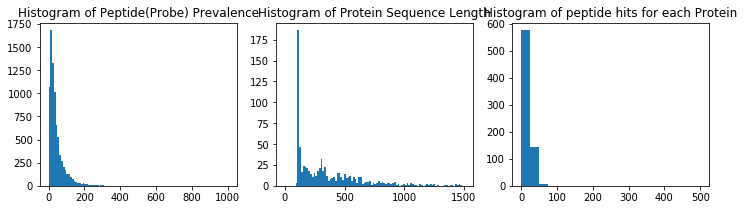

In [7]:
plt.figure(figsize=(12, 3))

axs=plt.subplot(131)
plt.title("Histogram of Peptide(Probe) Prevalence")
axs.hist(all_peptide_counts, bins=100, range=(0,1000))

axs=plt.subplot(132)
plt.title("Histogram of Protein Sequence Length")
axs.hist([len(p.seq) for p in pLst], bins=100, range=(0,1500))

axs=plt.subplot(133)
plt.title("Histogram of peptide hits for each Protein")
axs.hist([p.bf.count() for p in protLst], bins=20, range=(0,500))
plt.show()

In [8]:
iLst=[];plotLst=[]
protLst.sort(key=lambda x:-x.bf.count())
for p in protLst:
    row=[int(x) for x in list(p.bf.bin_str())]
    if random.random()<0.001:print(p.label, p.bf.array_sz, p.bf.max, len(row), p.bf.count(), len(p.bf.export_bit_idxLst()))
    iLst.append([p.label] + row)
    plotLst.append(row)
bf_img=np.array(iLst)
print(len(iLst))
img = Image.fromarray(bf_img, mode='1')
img.save('bf_img.jpg', format='JPEG', subsampling=0, quality=100)
LL=[N for N in bitmap.Lst]
extra_spacers=len(row)-len(LL)
LL=['seq_name']+LL+list(range(extra_spacers))
df = pd.DataFrame(iLst, columns=LL)
df.to_csv('hitmap.csv')

sp|A8K5M9|CO062_HUMAN 2 102 128 17 17
725


[Text(30.5,0.5,'Protein_subset'), Text(0.5,12.5,'Peptide n-mers')]

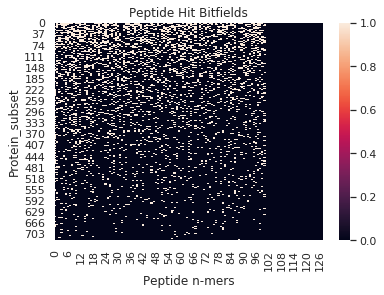

In [9]:
import seaborn as sns; sns.set()

plt.show()
ax = sns.heatmap([p[:] for p in plotLst])
plt.title("Peptide Hit Bitfields")
ax.set(xlabel='Peptide n-mers', ylabel='Protein_subset')

[Text(30.5,0.5,'Protein_idx'), Text(0.5,12.5,'Protein_idx')]

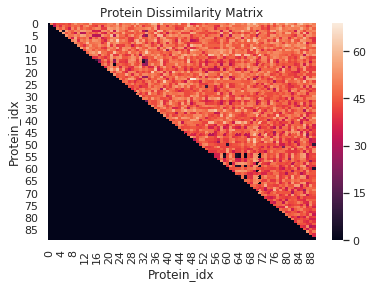

In [10]:
#dissimilarityMatrix
NumSeqs=90;pairLst=[]
DM=[[0 for x in range(NumSeqs)] for x in range(NumSeqs)]
for i in range(NumSeqs):
    a=protLst[i]
    for j in range(i, NumSeqs, 1):
        b=protLst[j]
        d=(a.bf)^(b.bf)
        DM[i][j]=d.count()
        pairLst.append([i,j,DM[i][j]])
pairLst.sort(key=lambda x:x[-1])
plt.show()
ax = sns.heatmap(DM)
plt.title("Protein Dissimilarity Matrix")
ax.set(xlabel='Protein_idx', ylabel='Protein_idx') 

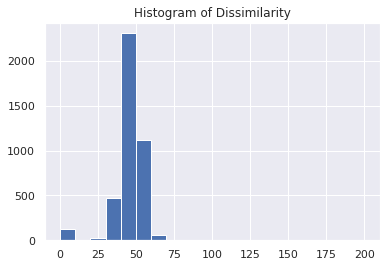

In [11]:
fig, axs = plt.subplots(tight_layout=False)
plt.title("Histogram of Dissimilarity")
yo=axs.hist([p[-1] for p in pairLst], bins=20, range=(0,200))

## Probe Choice

In [16]:
import multiprocessing as mp
from contextlib import closing
 
def chooseMostPrevalentProbe(probeLst, probe_bitmap, randomize=True):
    number_Lst=[probe_bitmap.d[probe] for probe in probeLst]
    if randomize:
        n_sum=sum(number_Lst)
        r=int(random.random()*n_sum)
        for i in range(len(number_Lst)):
            r-=number_Lst[i]
            if r<0:break
        return probeLst[i]
    else:
        return probeLst[np.argmax(number_Lst)]
    
    
def GenerateProbeSetBF(probeLst, probe_bitmap):
    probeset_bf=B.BitArray(probe_bitmap.n+1)
    for probe in probeLst:
        probe_idx=probe_bitmap.Lst.index(probe)
        probeset_bf[probe_idx]=1
    return probeset_bf

def ComputeProteinClusters(proteinLst, probeset_bf):
    """This function computes the number of clusters 
    given a set of proteins and choice of probes"""
    proteinprobehit_bfLst=[]
    dedup_dict={}
    for protein in proteinLst:
        pap=protein.bf&probeset_bf
        bstr=pap.bin_str()
        if not bstr in dedup_dict:dedup_dict[bstr]=0
        dedup_dict[bstr]+=1
        proteinprobehit_bfLst.append(pap)
    return len(dedup_dict)

    
def ComputeProteinClusters_DoesNotWork(proteinLst, probeset_bf):
    #ToDo: fin efficient/correct way to sort bitfields 
    """This function computes the number of clusters 
    given a set of proteins and choice of probes"""
    proteinprobehit_bfLst=[]
    for protein in proteinLst:
        pap=protein.bf&probeset_bf
        proteinprobehit_bfLst.append(pap)
    #dedupe rec count
    proteinprobehit_bfLst.sort()
    current_rec=proteinprobehit_bfLst[0]
    cluster_count=1
    for rec in proteinprobehit_bfLst:
        if rec!=current_rec:
            cluster_count+=1
            current_rec=rec
    return cluster_count

def ChoiceCycle(proteinLst, probe_bitmap, probeLst, choice_window=0):
    #Computes info gain for each remaining probe
    probeset_bf=GenerateProbeSetBF(probeLst, probe_bitmap)
    probe_choiceLst=[]
    for probe in probe_bitmap.Lst:
        if (probe in probeLst):continue
        probe_idx=probe_bitmap.Lst.index(probe)
        if probeset_bf[probe_idx]:continue
        probeset_bf[probe_idx]=1
        cluster_count, proteinprobehit_bfLst= ComputeProteinClusters(proteinLst, probeset_bf)
        probe_choiceLst.append([cluster_count, probe])
        probeset_bf[probe_idx]=0
    probe_choiceLst.sort(key=lambda x:-x[0])
    top_num_clusters=probe_choiceLst[0][0]
    choiceLst=[]
    for i in range(len(probe_choiceLst)):
        c=probe_choiceLst[i]
        if top_num_clusters-c[0]>=choice_window:
            choiceLst.append(c)
        else:
            break
    print('ChoiceCycle:probe_choiceLst:%i choiceLst:%i top_num_clusters:%i'%(len(probe_choiceLst),len(choiceLst), top_num_clusters))
    return choiceLst

def compute_protein_clusters_Runner(t):
    #For multiprocessing
    proteinLst, probeset_bf, probe_idx, probe = t
    probeset_bf[probe_idx]=1
    cluster_count= ComputeProteinClusters(proteinLst, probeset_bf)
    return [cluster_count, probe]
    
def ChoiceCycle_mp(proteinLst, probe_bitmap, probeLst, choice_window=0, num_ranks=12):
    #Computes info gain for each remaining probe
    #Multiprocessing version of ChoiceCycle
    probeset_bf=GenerateProbeSetBF(probeLst, probe_bitmap)
    probe_choiceLst=[]
    processingLst=[]
    for probe in probe_bitmap.Lst:
        if (probe in probeLst):continue
        probe_idx=probe_bitmap.Lst.index(probe)
        if probeset_bf[probe_idx]:continue
        processingLst.append([proteinLst, probeset_bf.copy(), probe_idx, probe])
    with closing( mp.Pool(num_ranks) ) as p:
        probe_choiceLst=p.map(compute_protein_clusters_Runner, processingLst)
    probe_choiceLst.sort(key=lambda x:-x[0])
    top_num_clusters=probe_choiceLst[0][0]
    choiceLst=[]
    for i in range(len(probe_choiceLst)):
        c=probe_choiceLst[i]
        if top_num_clusters-c[0]>=choice_window:
            choiceLst.append(c)
        else:
            break
    print('ChoiceCycle:probe_choiceLst:%i choiceLst:%i top_num_clusters:%i'%(len(probe_choiceLst),len(choiceLst), top_num_clusters))
    #print(choiceLst)
    return choiceLst

## Choice Routine:

In [17]:
probe_bitmap=bitmap
RND_CHOICE=False;NUM_RANKS=12
probeLst=[chooseMostPrevalentProbe(probe_bitmap.Lst, probe_bitmap, randomize=RND_CHOICE)]
cycleLst=[];cycleLL=['cycle', 'num_clusters', 'num_choice_possibilities', 'probeSet']
discernible_clusters=0;clusters_to_discern=len(protLst)
cycle=0;previous_discernible_clusters=0
while discernible_clusters < clusters_to_discern:
    cycle+=1
    choiceLst=ChoiceCycle_mp(protLst, bitmap, probeLst, choice_window=0, num_ranks=NUM_RANKS)
    prLst=[c[1] for c in choiceLst]
    probe=chooseMostPrevalentProbe(prLst, probe_bitmap, randomize=RND_CHOICE)
    choice_idx=prLst.index(probe)
    #Choose first of equals You can also choose randomly or choose from within choice_window range
    num_clusters,probe =choiceLst[choice_idx]
    if num_clusters>discernible_clusters:
        probeLst.append(probe)
        cycleLst.append([cycle, num_clusters, len(choiceLst), '|'.join(probeLst)])
        discernible_clusters=num_clusters
        print(cycle, num_clusters, len(choiceLst), probe)
    else:
        print('No more optimization is possible')
        break
    
print(probeLst)

ChoiceCycle:probe_choiceLst:100 choiceLst:100 top_num_clusters:4
1 4 100 SSS
ChoiceCycle:probe_choiceLst:99 choiceLst:99 top_num_clusters:8
2 8 99 PPP
ChoiceCycle:probe_choiceLst:98 choiceLst:98 top_num_clusters:16
3 16 98 AAA
ChoiceCycle:probe_choiceLst:97 choiceLst:97 top_num_clusters:32
4 31 97 EEE
ChoiceCycle:probe_choiceLst:96 choiceLst:96 top_num_clusters:59
5 57 96 SSL
ChoiceCycle:probe_choiceLst:95 choiceLst:95 top_num_clusters:96
6 92 95 LPP
ChoiceCycle:probe_choiceLst:94 choiceLst:94 top_num_clusters:141
7 140 94 SLL
ChoiceCycle:probe_choiceLst:93 choiceLst:93 top_num_clusters:194
8 186 93 LEE
ChoiceCycle:probe_choiceLst:92 choiceLst:92 top_num_clusters:239
9 238 92 LLA
ChoiceCycle:probe_choiceLst:91 choiceLst:91 top_num_clusters:289
10 283 91 LLG
ChoiceCycle:probe_choiceLst:90 choiceLst:90 top_num_clusters:334
11 316 90 LLE
ChoiceCycle:probe_choiceLst:89 choiceLst:89 top_num_clusters:359
12 352 89 ALL
ChoiceCycle:probe_choiceLst:88 choiceLst:88 top_num_clusters:389
13 378 88

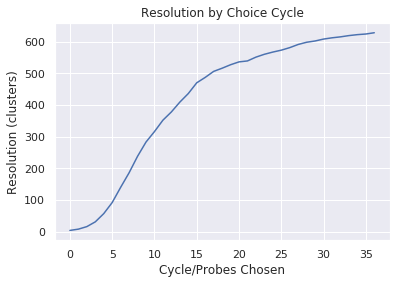

In [22]:
out_dir="./"
clst=[[r[0], r[1], len(r[3].split('|'))] for r in cycleLst]
df=pd.DataFrame(clst, columns=['cycle',
                                'num_clusters', 
                                'num_probes'])
df.to_csv(out_dir+'choice_cycle_run.csv')

plt.plot(list(range(len(clst))), [c[1] for c in clst])
plt.title("Resolution by Choice Cycle")

plt.xlabel('Cycle/Probes Chosen')
plt.ylabel('Resolution (clusters)')
plt.show()

## Protein Digestion:  

https://pyopenms.readthedocs.io/en/latest/installation.html  

https://readthedocs.org/projects/pyopenms/downloads/pdf/release_2.4.0/

In [20]:
from pyopenms import *

p=ProteaseDB()
n=[]
p.getAllNames(n)

def digest(enz, fa_file, rngLst=[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000]):
    dig.setEnzyme(enz)
    size_dict={}
    fa = pyfastx.Fasta(huprot_path)
    oLst=[]
    for seq in fa_file:
        result = []
        s=seq.seq;name=seq.name;
        prefix, acc=name.split('|')[0:2]
        if prefix=='tr':continue
        dig.digest(AASequence.fromString(s), result)
        result=[r.toString() for r in result]
        print(name, len(result), end='\r')
        for i in range(len(rngLst)-1):
            min_sz=rngLst[i];max_sz=rngLst[i+1]
            mami='%i_%i'%(min_sz, max_sz)
            if not(mami in size_dict):size_dict[mami]={}
            l=list(filter(lambda x:min_sz<=len(x)<max_sz, result))
            if l:
                size_dict[mami][acc]=l
    return size_dict

In [24]:
huprot_path="/tdata2/human_proteome/UP000005640_9606.fasta"

dig = ProteaseDigestion()
oLst=[];LL=['enz', 'size_range', 'num_proteins', 'avg_frags', 'stdev_frags']

enz_names=[
    b'Trypsin',
         b'Clostripain/P',
         b'Glu-C+P',
         b'TrypChymo',
         b'Arg-C/P',
         b'V8-E',
         b'Chymotrypsin',
         b'elastase-trypsin-chymotrypsin',
         b'staphylococcal protease/D',
         b'Trypsin/P',
         #b'unspecific cleavage',
         b'Chymotrypsin/P',
         b'proline-endopeptidase/HKR',
         b'PepsinA + P',
         b'cyanogen-bromide',
         #b'CNBr',
         b'V8-DE',
         b'Lys-C/P',
         b'leukocyte elastase',
         b'proline endopeptidase',
         b'glutamyl endopeptidase',
         b'Alpha-lytic protease',
         b'2-iodobenzoate',
         b'iodosobenzoate',
         b'Arg-C',
         b'Asp-N/B',
         b'Lys-C',
         b'PepsinA',
         b'Asp-N_ambic',
         b'Lys-N',
         b'Formic_acid',
         b'Asp-N',
         #b'no cleavage'
          ]

enz_names=[
    b'Asp-N/B'#,b'CNBr',
]
#p.getAllNames(enz_names)
rngLst=[50, 200]#[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000])
for enz in enz_names:
    print(enz)
    dig.setEnzyme(enz)
    size_dict=digest(enz, fa_file, rngLst=rngLst)
    for i in range(len(rngLst)-1):
        min_sz=rngLst[i];max_sz=rngLst[i+1]
        mami='%i_%i'%(min_sz, max_sz)
        clst = np.array([len(size_dict[mami][k]) for k in size_dict[mami].keys()])
        oLst.append([enz, mami, len(size_dict[mami]), clst.mean(), clst.std()])
df = pd.DataFrame(oLst, columns=LL)
enz_str=str(enz).replace(' ','').replace('/', '-').replace('+','plus').replace("'", '')[1:]
df.to_csv('all_digestions50-200.csv')
df

b'Asp-N/B'


,enz,size_range,num_proteins,avg_frags,stdev_frags
0,b'Asp-N/B',50_200,16922,2.847358,2.723181


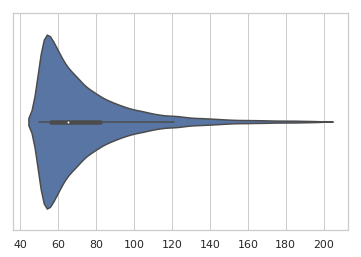

In [27]:
import seaborn as sns

fragLst=[]
for k in size_dict[mami].keys():
    fragLst.extend([len(x) for x in size_dict[mami][k]])
sns.set(style="whitegrid")
ax = sns.violinplot(x=fragLst)